In [109]:
import importlib
import os
import sys
from IPython.display import Image, display
import datetime
import geopandas

import argparse
import datetime
import gc
from utility_programs.read_routines import GITM
import os
import time
import glob
from multiprocessing import Pool

import geopandas
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from tqdm.auto import tqdm

from utility_programs.plot_help import UT_from_Storm_onset
from utility_programs.filters import make_fits
import  utility_programs.plotting_routines

In [145]:
plotting_routines = importlib.reload(utility_programs.plotting_routines)

# Figure 2: GITM Map Panel

Total Neutral Density at an Altitude

In [139]:
world = geopandas.read_file(
        geopandas.datasets.get_path("naturalearth_lowres"))
cols = ['Rho']
gitm_dir = "/petastore/phil/GITM/cheyenne_runs/FullAmp/data/"
out_path = "/home/axb170054/scratch/made_plots/SimStormPaper/figures/fig2/"
dtime_storm_start = datetime.datetime(2011,5,21,12)
gitm_alt_idxs = [35]

In [63]:



times, gitm_grid, gitm_bins = GITM.read_gitm_into_nparrays(
        gitm_dir=gitm_dir,
        dtime_storm_start=dtime_storm_start,
        cols=cols,
        t_start_idx=2,
        t_end_idx=7)

  0%|          | 0/108 [00:00<?, ?it/s]

In [67]:
print("Calculating fits. This will take a moment...")
fits_gitm = make_fits(gitm_bins)

Calculating fits. This will take a moment...


In [70]:
gitm_bins.shape

(108, 1, 90, 180, 50)

In [72]:
hrs_since_storm_onset = np.array([(i - pd.Timestamp(dtime_storm_start))
                                      / pd.Timedelta('1 hour') for i in times])

lats, lons, alts = (
        np.unique(gitm_grid["latitude"]),
        np.unique(gitm_grid["longitude"]),
        np.unique(gitm_grid["altitude"]))




In [151]:
gitm_alt_idxs

[35]

In [148]:
sel_times = times[26],times[32], times[38], times[42], times[48], times[52]
sel_times

(datetime.datetime(2011, 5, 21, 12, 10),
 datetime.datetime(2011, 5, 21, 12, 40),
 datetime.datetime(2011, 5, 21, 13, 10),
 datetime.datetime(2011, 5, 21, 13, 30),
 datetime.datetime(2011, 5, 21, 14, 0),
 datetime.datetime(2011, 5, 21, 14, 20))

In [149]:
for col in cols:
    numcol = cols.index(col)
    for alt_idx in gitm_alt_idxs:
        for dtime_real in sel_times:
            
            dtime_index = np.argmin(np.abs(np.array(times) - dtime_real))
             
             
            raw = gitm_bins[dtime_index, numcol, :, :, alt_idx].copy()
            bandpass = fits_gitm[dtime_index, numcol, :, :, alt_idx].copy()
            real_alt = alts[alt_idx]
            percent = 100 * (raw - bandpass) / raw

            title = (
                "Neutral Density Perturbation at "
                + str(round(float(real_alt) / 1000, 0))
                + " km at "
                + UT_from_Storm_onset(dtime_real, dtime_storm_start)
                + " from Storm Start")
            
            
            fname = os.path.join(
                out_path, 
                str(dtime_index).rjust(3, "0") + ".png",)
            cbarlims = [vmin_diffs, vmax_diffs]
            cbar_label = "% over Background"
            plotting_routines.draw_map(
                percent,
                title,
                cbarlims = [-5,5],
                save_or_show='save',
                cbar_label=cbar_label,
                fname=fname,OVERWRITE=True)


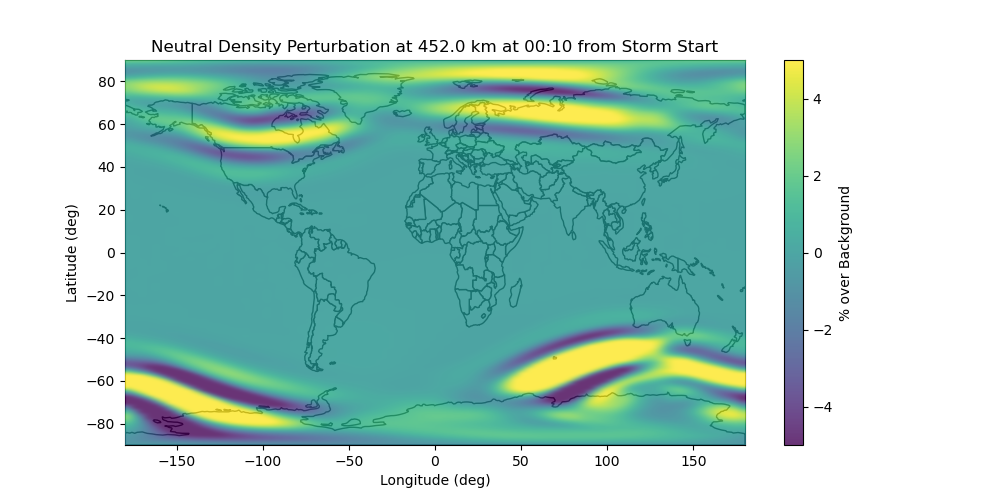

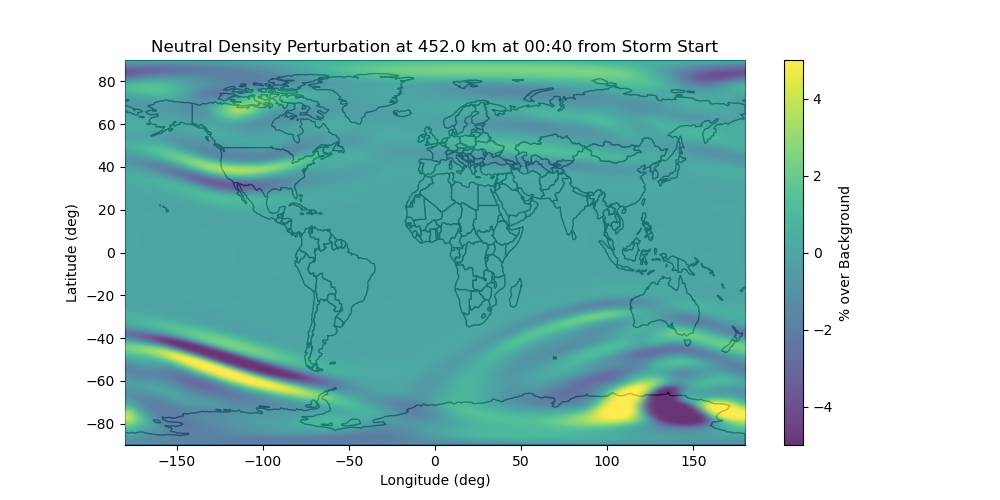

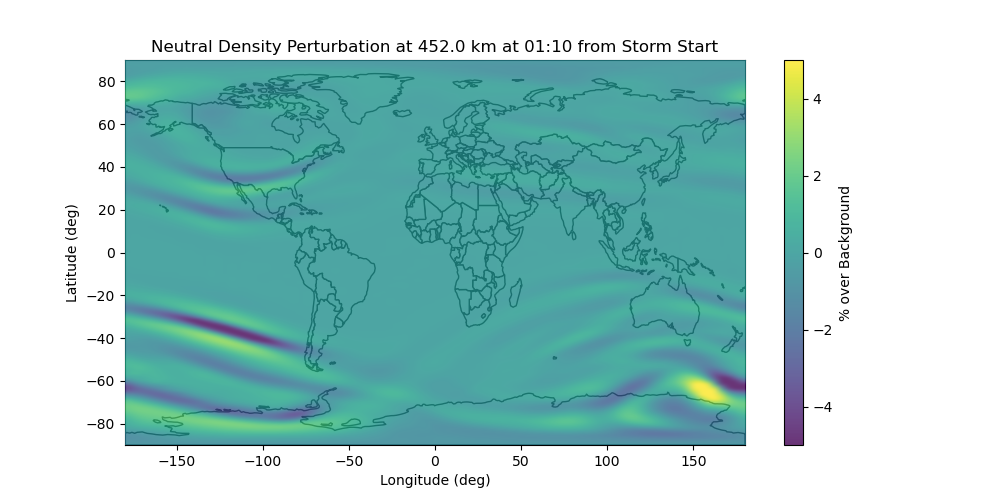

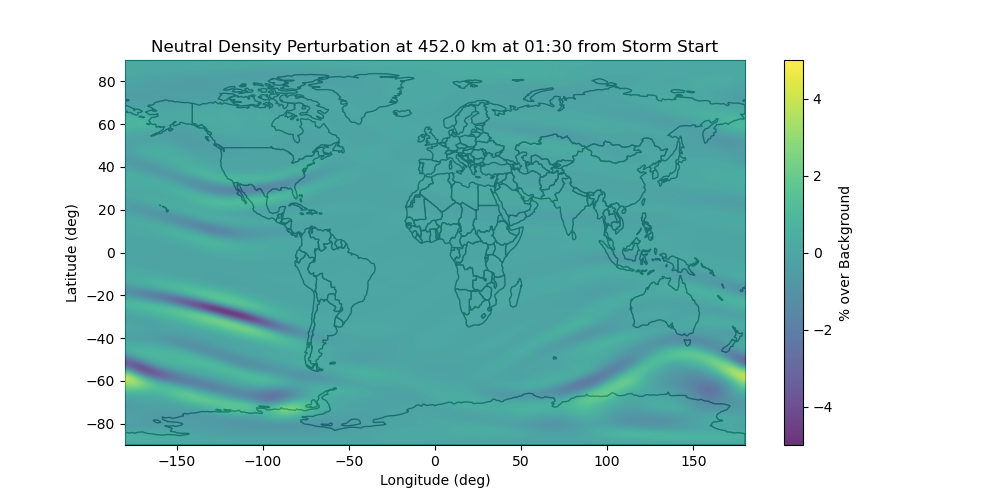

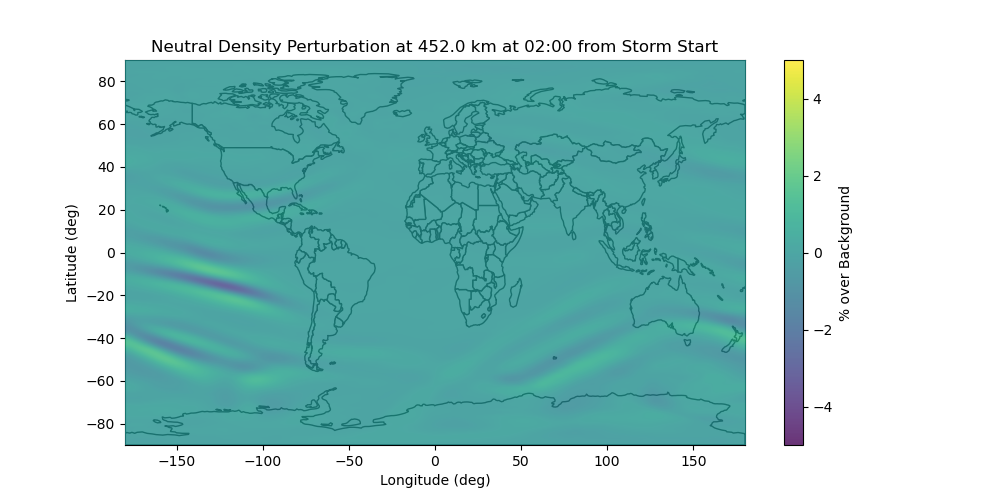

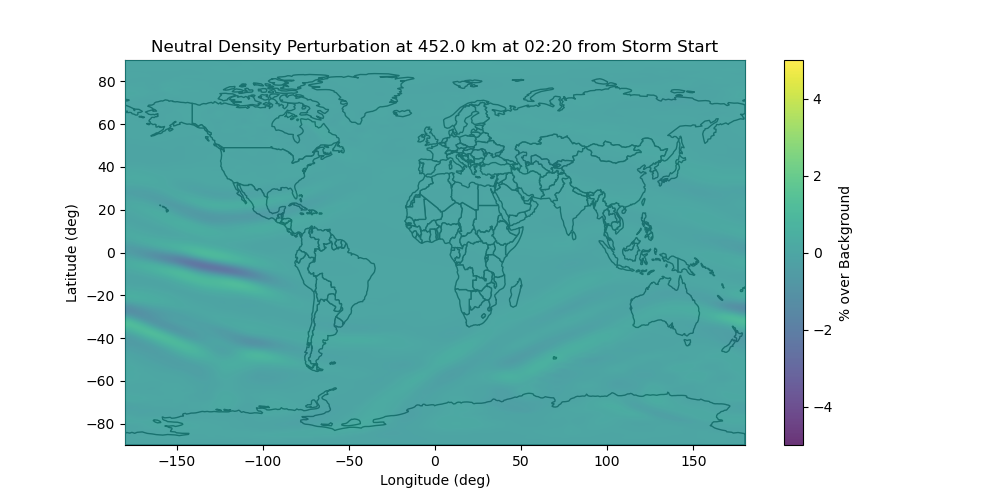

In [150]:
listOfImageNames = np.sort(glob.glob(out_path + "*.png"))

for imageName in listOfImageNames:
    display(Image(filename=imageName))

# Figure 1: GITM Keogram



In [ ]:
d = {}
d[' '] = '2011052112'
d['-gitm_data_path'] = '/petastore/phil/GITM/cheyenne_runs/FullAmp/data/'
d['--out_path'] = \
    '/home/axb170054/scratch/made_plots/SimStormPaper/figures/fig1/'
d['--cols'] = 'Rho'
d['--plot_start_delta'] = 2
d['--plot_end_delta'] = 7
d['-k'] = ' '

file = 'gitm_basic_plots'

command = 'python ' + 'gitm_basic_plots.py '
for k in d.keys():
    command += k +' ' + str(d[k]) +' '

print(command)

In [ ]:
os.system(command)

In [ ]:
listOfImageNames = ['/path/to/images/1.png',
                    '/path/to/images/2.png']

for imageName in listOfImageNames:
    display(Image(filename=imageName))

# Figure 3: Two plots of GITM's Joule Heating

In [ ]:
times2, gitm_grid2, gitm_f2, gitm_vars2 = GITM.read_gitm_into_nparrays(
            args.gitm_data_path, dtime_storm_start,
            gitm_file_pattern='2DANC*.bin',
            t_start_idx=args.plot_start_delta,
            t_end_idx=args.plot_end_delta, return_vars=True)

lats = np.unique(gitm_grid2['latitude'])
lons = np.unique(gitm_grid2['longitude'])

polar_data = gitm_f2[:, gitm_vars2.index(
        'AltIntJouleHeating(W/m2)'), :, :].copy().reshape(new_shape)

maskNorth = ((lats > 45))
maskSouth = ((lats < -45))

minP = 1.2 * np.min(polar_data)
maxP = 0.8 * np.max(polar_data)



In [ ]:
for i, dtime in enumerate(
    [datetime.datetime(2011,5,21,10), datetime.datetime(2011,5,21,13)]):

    fig = plt.figure(figsize=(10, 8.5))
    fig.suptitle('%s UT from storm onset \n (%s) UT'
                    % (UT_from_Storm_onset(
                        dtime, dtime_storm_start),
                    str(dtime)), fontsize=15)

    gs1 = GridSpec(nrows=1, ncols=2, wspace=.1, hspace=.1)
    ax0 = fig.add_subplot(gs1[0, 0], projection='polar')
    ax1 = fig.add_subplot(gs1[0, 1], projection='polar')

    # add in plots. polar left, polar right, map
    r, theta = np.meshgrid(90-lats[maskNorth], lons)
    ax0.pcolor(np.deg2rad(theta), r,
                poldata[nt, :, maskNorth].T.copy(),
                vmin=minP, vmax=maxP)

    ylabels = ['80', '70', '60', '50']
    ax0.set_yticklabels(ylabels)
    ax0.set_xticks(np.arange(0, 2*np.pi, np.pi/2))
    ax0.set_yticks(np.arange(10, 50, 10))
    ax0.set_title('North')

    r, theta = np.meshgrid(lats[maskSouth], lons)
    cb = ax1.pcolor(np.deg2rad(theta), r,
                    poldata[nt, :, maskSouth].T.copy(),
                    vmin=minP, vmax=maxP)
    ylabels = ['-80', '-70', '-60', '-50']
    ax1.set_yticklabels(ylabels)
    ax1.set_title('South')
    fig.colorbar(cb, ax=ax1,
                    label=p_fig + ' ' + args.polar_var)
    
    # plt.savefig('~/scratch/made_plots/SimStormPaper/figures/fig3/' + i)